In [1]:
!mkdir '/content/salamm'

In [2]:
import numpy as np 
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/salamm'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [4]:
!cp "/content/drive/MyDrive/nct/project_folder/image_salam.tif" "/content/salamm"
!cp "/content/drive/MyDrive/nct/project_folder/annotation_salam.tif" "/content/salamm"

In [5]:
!mkdir '/content/salamm/images'
!mkdir '/content/salamm/masks'

In [6]:
from PIL import Image, ImageSequence

im = Image.open("/content/salamm/image_salam.tif")   #/content/salam/image.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salamm/images/Page%d.png" % i)

In [7]:
from PIL import Image, ImageSequence

im = Image.open("/content/salamm/annotation_salam.tif")   #/content/salam/image.tif

for i, page in enumerate(ImageSequence.Iterator(im)):
    page.save("/content/salamm/masks/Page%d.png" % i)

In [8]:
import cv2
from matplotlib import pyplot as plt

image_data = []
images_path = sorted(os.listdir('/content/salamm/images'))
for image_name in images_path:
        image = cv2.imread('/content/salamm/images/' + image_name, 0)
        image = cv2.resize(image, dsize=(768,512), interpolation=cv2.INTER_AREA)
        image_data.append(np.array(image))
        
        
mask_data = []
mask_path = sorted(os.listdir('/content/salamm/masks'))
for mask_name in mask_path:
        mask = cv2.imread('/content/salamm/masks/' + mask_name, 0)
        mask = cv2.resize(mask, dsize=(768,512), interpolation=cv2.INTER_AREA)
        mask_data.append(np.array(mask))
        
        
image_data = np.expand_dims(np.array(image_data),3) / 255
mask_data = np.expand_dims(np.array(mask_data),3) / 255

In [9]:
print(image_data.shape, mask_data.shape)


(80, 512, 768, 1) (80, 512, 768, 1)


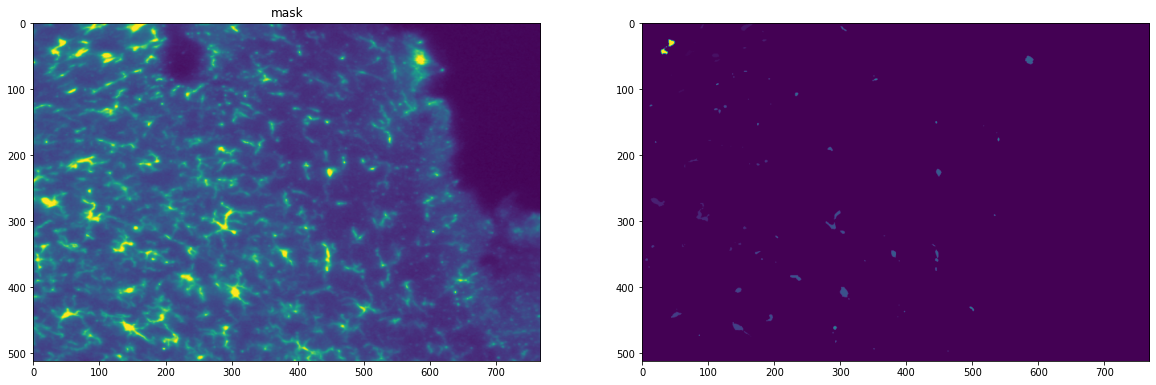

In [13]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(np.squeeze(image_data[0]))
ax[0].set_title('image')
ax[1].imshow(np.squeeze(mask_data[0]))
ax[0].set_title('mask')
fig.show()

In [14]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout

#U-net model

s = Input((image_data.shape[1], image_data.shape[2], image_data.shape[3]))

#Contraction path
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = Dropout(0.2)(c1)
c1 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.3)(c2)
c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.4)(c3)
c3 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

#Expansive path 
u4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, c2])
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c4 = Dropout(0.4)(c4)
c4 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

u5 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = concatenate([u5, c1], axis=3)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = Dropout(0.3)(c5)
c5 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

model = Model(inputs=[s], outputs=[outputs])
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 768, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 768, 8)  80          ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 512, 768, 8)  0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 768, 8)  584         ['dropout[0][0]']            

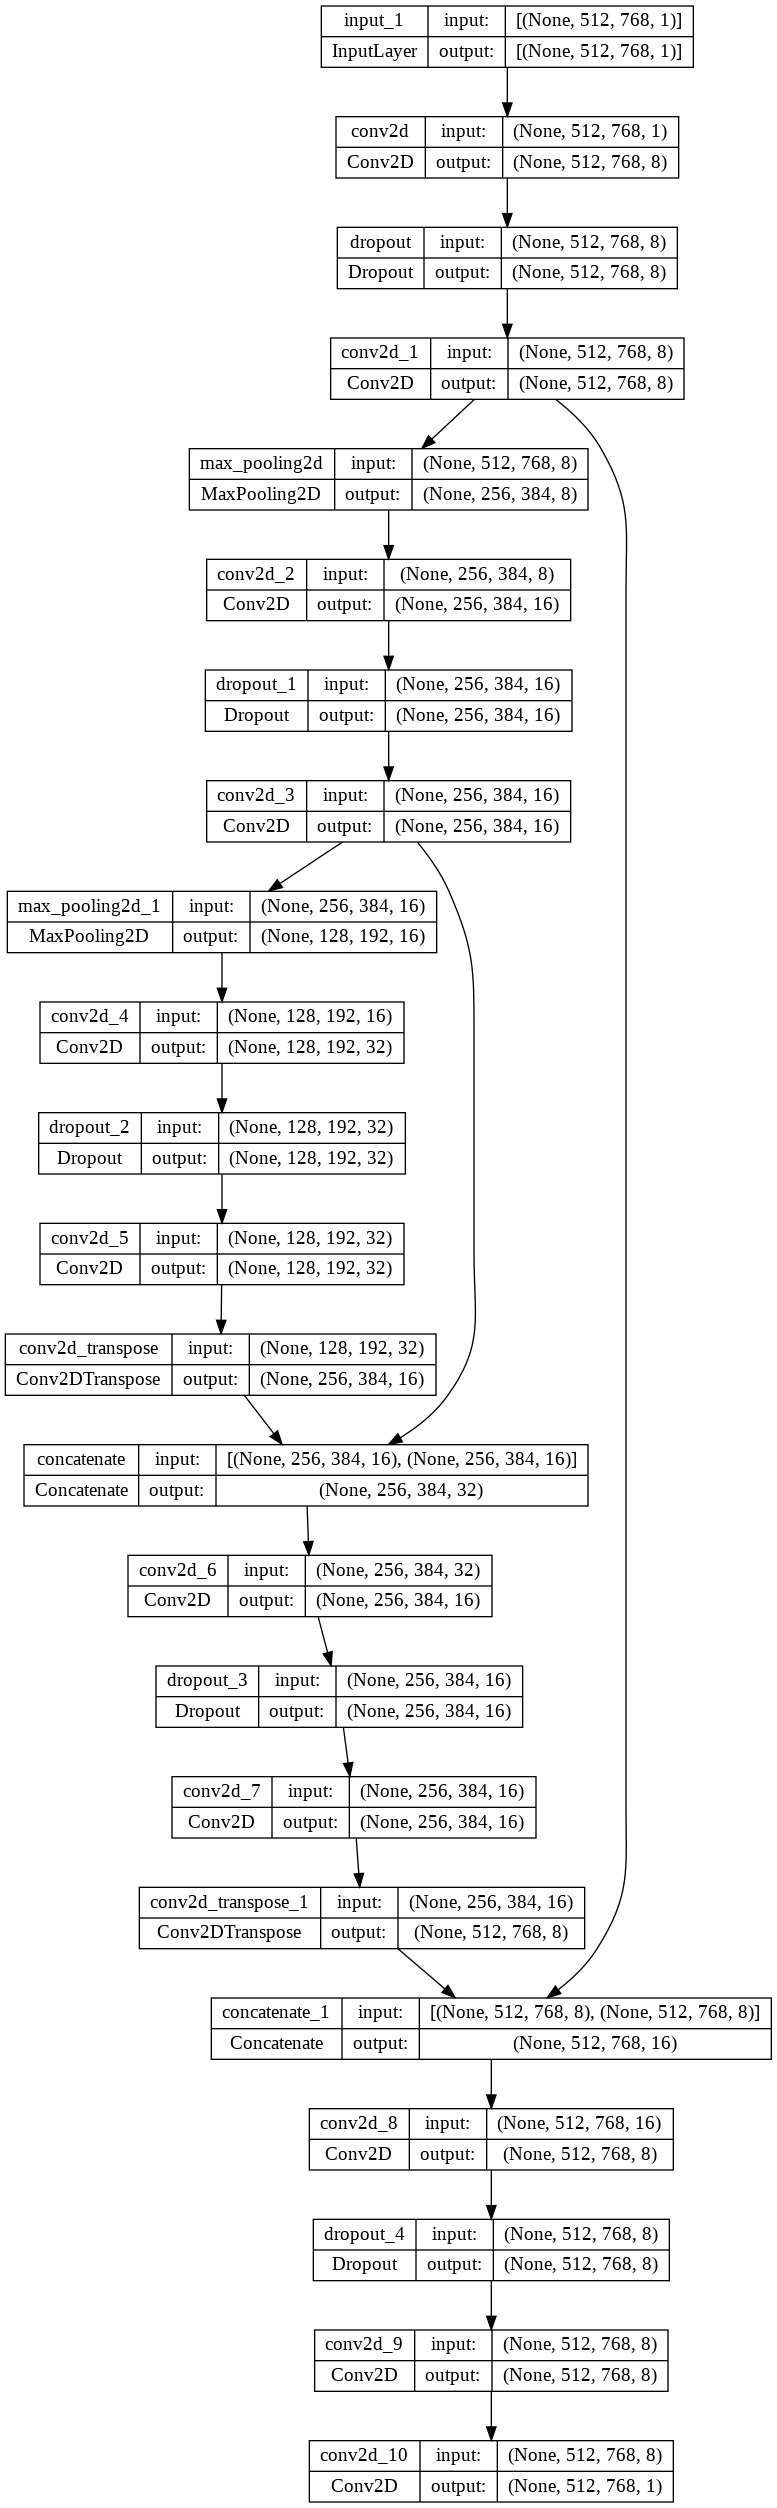

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_data, mask_data, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print('train data size:', X_train.shape[0], '\n')
print('validation data size:', X_val.shape[0], '\n')
print('test data size:', X_test.shape[0])

train data size: 64 

validation data size: 8 

test data size: 8


In [22]:
history = model.fit(x = X_train,
                    y = y_train,
                    batch_size = 16,
                    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=25)],
                    validation_data = (X_val, y_val),
                    verbose = 1,
                    epochs = 30)

Epoch 1/30
4/4 [==============================] - 2s 453ms/step - loss: 0.0452 - accuracy: 0.9923 - val_loss: 0.0825 - val_accuracy: 0.9924
Epoch 2/30
4/4 [==============================] - 2s 441ms/step - loss: 0.0411 - accuracy: 0.9923 - val_loss: 0.0865 - val_accuracy: 0.9924
Epoch 3/30
4/4 [==============================] - 2s 438ms/step - loss: 0.0371 - accuracy: 0.9923 - val_loss: 0.0844 - val_accuracy: 0.9924
Epoch 4/30
4/4 [==============================] - 2s 440ms/step - loss: 0.0329 - accuracy: 0.9923 - val_loss: 0.0807 - val_accuracy: 0.9924
Epoch 5/30
4/4 [==============================] - 2s 442ms/step - loss: 0.0287 - accuracy: 0.9923 - val_loss: 0.0704 - val_accuracy: 0.9924
Epoch 6/30
4/4 [==============================] - 2s 439ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.0748 - val_accuracy: 0.9924
Epoch 7/30
4/4 [==============================] - 2s 442ms/step - loss: 0.0228 - accuracy: 0.9923 - val_loss: 0.0479 - val_accuracy: 0.9924
Epoch 8/30
4/4 [====

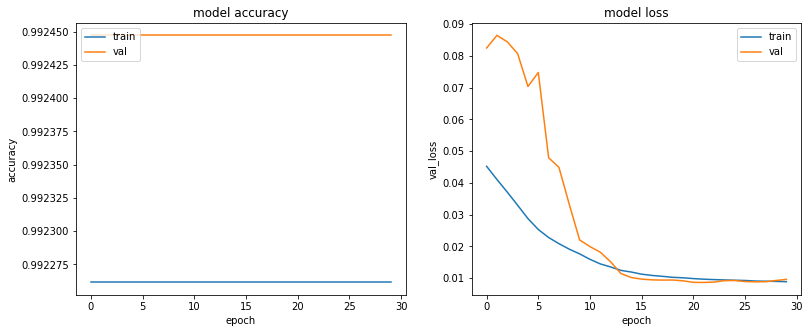

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(13,5))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('val_loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper right')

fig.show()

1/1 [==============================] - 0s 34ms/step


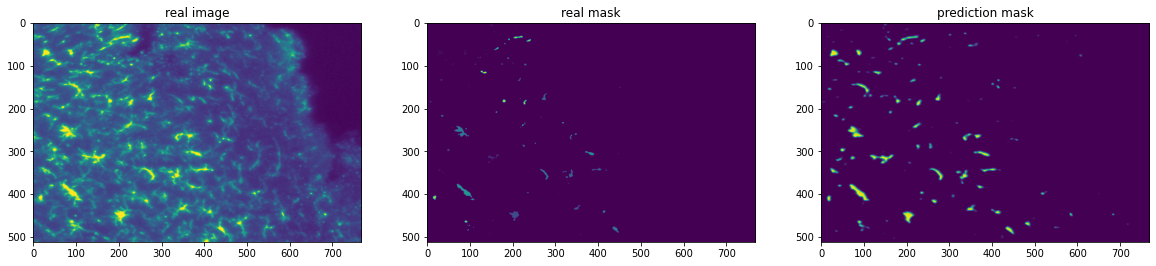

In [27]:
rndm_img = np.random.randint(0,len(X_test))

fig, ax = plt.subplots(1,3, figsize=(20,20))
ax[0].imshow(np.squeeze(X_test[rndm_img]))
ax[0].set_title('real image')

ax[1].imshow(np.squeeze(y_test[rndm_img]))
ax[1].set_title('real mask')

test_img = np.expand_dims(X_test[rndm_img], axis=0)
rslt = model.predict(test_img)[0]
ax[2].imshow(np.squeeze(rslt))
ax[2].set_title('prediction mask')

fig.show()